In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import scipy.io
import os

# For data preprocessing and splitting
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# For one-hot encoding
from tensorflow.keras.utils import to_categorical

# For building the ANN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


2025-03-30 16:43:35.350778: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 16:43:35.407446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743333215.476548   29864 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743333215.493425   29864 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743333215.546036   29864 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# 1. Load Feature Data from MAT File
data_smooth = scipy.io.loadmat("feature_extraction/features_shog_smooth.mat")
A = data_smooth['A']  # Use 'A' from data_smooth

# Extract label, partition (if needed), and feature vectors from A
y = A[:, 0]        # First column: Category ID
features = A[:, 2:]   # Columns 3-...: Feature vectors

# Ensure `y` contains valid integer categorical labels
y = y.astype(int)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(np.unique(y_encoded))
y_cat = to_categorical(y_encoded, num_classes=num_classes)

In [3]:
# 2. Normalize Features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [4]:
# 3. Split the Dataset into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.2, random_state=42)

In [5]:
# 4. Apply LDA (Supervised Dimensionality Reduction)
# Note: n_components must be <= num_classes - 1. In some cases, a very low dimensionality
# might discard useful information. Consider experimenting with PCA or using a hybrid PCA+LDA.
lda = LDA(n_components=num_classes - 1)
X_train_lda = lda.fit_transform(X_train, np.argmax(y_train, axis=1))
X_test_lda = lda.transform(X_test)
print("LDA transformed shape:", X_train_lda.shape)

LDA transformed shape: (16000, 249)


In [15]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation

model = Sequential()

# First Dense Block: Larger layer with regularization
model.add(Dense(1024, kernel_regularizer=l2(0.001), input_shape=(X_train_lda.shape[1],)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Second Dense Block
model.add(Dense(512, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

# Third Dense Block
model.add(Dense(256, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Fourth Dense Block
model.add(Dense(128, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1024)           │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 250)            │        32,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 984,954 (3.76 MB)

 Trainable params: 981,114 (3.74 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [16]:
# 6. Setup Callbacks for Training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ModelCheckpoint("best_ann_model.h5", monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

In [17]:
# 7. Train the ANN Model
history = model.fit(X_train_lda, y_train,
                    epochs=100,            # Increased number of epochs
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=callbacks,
                    verbose=1)

# Load best weights (if saved)
if os.path.exists("best_ann_model.h5"):
    model.load_weights("best_ann_model.h5")

Epoch 1/100
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0120 - loss: 7.2062

400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.0121 - loss: 7.2052 - val_accuracy: 0.1716 - val_loss: 6.0604 - learning_rate: 0.0010
Epoch 2/100
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1195 - loss: 6.0172

400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.1195 - loss: 6.0160 - val_accuracy: 0.2669 - val_loss: 4.8689 - learning_rate: 0.0010
Epoch 3/100
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1998 - loss: 5.0054

400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.1999 - loss: 5.0045 - val_accuracy: 0.3459 - val_loss: 4.2093 - learning_rate: 0.0010
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2653 - loss: 4.4467

400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.2653 - loss: 4.4467 - val_accuracy: 0.3894 - val_loss: 3.8664 - learning_rate: 0.0010
Epoch 5/100
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3157 - loss: 4.0985

400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.3156 - loss: 4.0988 - val_accuracy: 0.4166 - val_loss: 3.7062 - learning_rate: 0.0010
Epoch 6/100
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3383 - loss: 3.9836

400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3382 - loss: 3.9840 - val_accuracy: 0.4263 - val_loss: 3.6529 - learning_rate: 0.0010
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3553 - loss: 3.8763

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3553 - loss: 3.8764 - val_accuracy: 0.4425 - val_loss: 3.5798 - learning_rate: 0.0010
Epoch 8/100
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3792 - loss: 3.7621

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3792 - loss: 3.7624 - val_accuracy: 0.4525 - val_loss: 3.5301 - learning_rate: 0.0010
Epoch 9/100
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4022 - loss: 3.6818

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4021 - loss: 3.6822 - val_accuracy: 0.4625 - val_loss: 3.5330 - learning_rate: 0.0010
Epoch 10/100
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4156 - loss: 3.6425

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4156 - loss: 3.6429 - val_accuracy: 0.4666 - val_loss: 3.5309 - learning_rate: 0.0010
Epoch 11/100
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4194 - loss: 3.6254

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4193 - loss: 3.6261 - val_accuracy: 0.4712 - val_loss: 3.5514 - learning_rate: 0.0010
Epoch 12/100
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4428 - loss: 3.5453

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4427 - loss: 3.5462 - val_accuracy: 0.4787 - val_loss: 3.5359 - learning_rate: 0.0010
Epoch 13/100
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4429 - loss: 3.5305

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.4428 - loss: 3.5312 - val_accuracy: 0.4803 - val_loss: 3.5720 - learning_rate: 0.0010
Epoch 14/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4705 - loss: 3.4039

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4705 - loss: 3.4038 - val_accuracy: 0.5050 - val_loss: 3.3563 - learning_rate: 5.0000e-04
Epoch 15/100
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5209 - loss: 3.1206

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5209 - loss: 3.1207 - val_accuracy: 0.5056 - val_loss: 3.2715 - learning_rate: 5.0000e-04
Epoch 16/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5259 - loss: 3.0181

400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5258 - loss: 3.0181 - val_accuracy: 0.5081 - val_loss: 3.2019 - learning_rate: 5.0000e-04
Epoch 17/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5355 - loss: 2.9260 - val_accuracy: 0.5078 - val_loss: 3.1762 - learning_rate: 5.0000e-04
Epoch 18/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5448 - loss: 2.8453

400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5448 - loss: 2.8453 - val_accuracy: 0.5172 - val_loss: 3.1444 - learning_rate: 5.0000e-04
Epoch 19/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5463 - loss: 2.7948 - val_accuracy: 0.5094 - val_loss: 3.1340 - learning_rate: 5.0000e-04
Epoch 20/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5457 - loss: 2.7436 - val_accuracy: 0.5156 - val_loss: 3.1096 - learning_rate: 5.0000e-04
Epoch 21/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5618 - loss: 2.7180 - val_accuracy: 0.5016 - val_loss: 3.1176 - learning_rate: 5.0000e-04
Epoch 22/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5757 - loss: 2.6602 - val_accuracy: 0.5131 - val_loss: 3.0976 - learning_rate: 5.0000e-04
Epoch 23/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5815 - loss: 2.6284 - val_accuracy: 0.5156 - val_loss: 3.0856 - learning_rate: 5.0000e-04
Epoch 24/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step 

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5808 - loss: 2.5752 - val_accuracy: 0.5219 - val_loss: 3.1018 - learning_rate: 5.0000e-04
Epoch 26/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5900 - loss: 2.5371

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5900 - loss: 2.5372 - val_accuracy: 0.5269 - val_loss: 3.0848 - learning_rate: 5.0000e-04
Epoch 27/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6011 - loss: 2.5223 - val_accuracy: 0.5209 - val_loss: 3.0751 - learning_rate: 5.0000e-04
Epoch 28/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6102 - loss: 2.4639 - val_accuracy: 0.5256 - val_loss: 3.0913 - learning_rate: 5.0000e-04
Epoch 29/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5965 - loss: 2.4785 - val_accuracy: 0.5213 - val_loss: 3.0984 - learning_rate: 5.0000e-04
Epoch 30/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6071 - loss: 2.4784 - val_accuracy: 0.5200 - val_loss: 3.1019 - learning_rate: 5.0000e-04
Epoch 31/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6092 - loss: 2.4564 - val_accuracy: 0.5219 - val_loss: 3.0983 - learning_rate: 5.0000e-04
Epoch 32/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - ac

400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6272 - loss: 2.3720 - val_accuracy: 0.5381 - val_loss: 3.0489 - learning_rate: 2.5000e-04
Epoch 34/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6481 - loss: 2.2552 - val_accuracy: 0.5341 - val_loss: 3.0220 - learning_rate: 2.5000e-04
Epoch 35/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6591 - loss: 2.1975 - val_accuracy: 0.5312 - val_loss: 2.9996 - learning_rate: 2.5000e-04
Epoch 36/100
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6675 - loss: 2.1605

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6675 - loss: 2.1605 - val_accuracy: 0.5412 - val_loss: 2.9973 - learning_rate: 2.5000e-04
Epoch 37/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6709 - loss: 2.1005 - val_accuracy: 0.5303 - val_loss: 2.9788 - learning_rate: 2.5000e-04
Epoch 38/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.6827 - loss: 2.0615 - val_accuracy: 0.5403 - val_loss: 2.9688 - learning_rate: 2.5000e-04
Epoch 39/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.6834 - loss: 2.0183 - val_accuracy: 0.5241 - val_loss: 2.9643 - learning_rate: 2.5000e-04
Epoch 40/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6883 - loss: 2.0160 - val_accuracy: 0.5375 - val_loss: 2.9500 - learning_rate: 2.5000e-04
Epoch 41/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6851 - loss: 1.9707 - val_accuracy: 0.5384 - val_loss: 2.9545 - learning_rate: 2.5000e-04
Epoch 42/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step

400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.7103 - loss: 1.8401 - val_accuracy: 0.5425 - val_loss: 2.9239 - learning_rate: 2.5000e-04
Epoch 48/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.7089 - loss: 1.8239 - val_accuracy: 0.5403 - val_loss: 2.9146 - learning_rate: 2.5000e-04
Epoch 49/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7108 - loss: 1.7925 - val_accuracy: 0.5409 - val_loss: 2.9347 - learning_rate: 2.5000e-04
Epoch 50/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7076 - loss: 1.8064 - val_accuracy: 0.5412 - val_loss: 2.9144 - learning_rate: 2.5000e-04
Epoch 51/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7242 - loss: 1.7524

400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.7242 - loss: 1.7525 - val_accuracy: 0.5431 - val_loss: 2.9204 - learning_rate: 2.5000e-04
Epoch 52/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7249 - loss: 1.7439 - val_accuracy: 0.5391 - val_loss: 2.9140 - learning_rate: 2.5000e-04
Epoch 53/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7215 - loss: 1.7661 - val_accuracy: 0.5381 - val_loss: 2.9307 - learning_rate: 2.5000e-04
Epoch 54/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7248 - loss: 1.7205 - val_accuracy: 0.5406 - val_loss: 2.9354 - learning_rate: 2.5000e-04
Epoch 55/100
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7183 - loss: 1.7434

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7182 - loss: 1.7438 - val_accuracy: 0.5450 - val_loss: 2.9097 - learning_rate: 2.5000e-04
Epoch 56/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7189 - loss: 1.7399 - val_accuracy: 0.5412 - val_loss: 2.9371 - learning_rate: 2.5000e-04
Epoch 57/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7260 - loss: 1.7157 - val_accuracy: 0.5419 - val_loss: 2.9345 - learning_rate: 2.5000e-04
Epoch 58/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.7272 - loss: 1.7074 - val_accuracy: 0.5431 - val_loss: 2.9163 - learning_rate: 2.5000e-04
Epoch 59/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7272 - loss: 1.6783 - val_accuracy: 0.5403 - val_loss: 2.9253 - learning_rate: 2.5000e-04
Epoch 60/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7368 - loss: 1.6733 - val_accuracy: 0.5394 - val_loss: 2.9244 - learning_rate: 2.5000e-04
Epoch 61/100
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - ac

400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7342 - loss: 1.6679 - val_accuracy: 0.5484 - val_loss: 2.8973 - learning_rate: 1.2500e-04
Epoch 62/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7582 - loss: 1.5770 - val_accuracy: 0.5481 - val_loss: 2.9024 - learning_rate: 1.2500e-04
Epoch 63/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.7598 - loss: 1.5781 - val_accuracy: 0.5431 - val_loss: 2.8918 - learning_rate: 1.2500e-04
Epoch 64/100
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7725 - loss: 1.5316

400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.7724 - loss: 1.5317 - val_accuracy: 0.5497 - val_loss: 2.8938 - learning_rate: 1.2500e-04
Epoch 65/100
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7715 - loss: 1.4970

400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7715 - loss: 1.4972 - val_accuracy: 0.5503 - val_loss: 2.8808 - learning_rate: 1.2500e-04
Epoch 66/100
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7692 - loss: 1.5100

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7692 - loss: 1.5101 - val_accuracy: 0.5509 - val_loss: 2.8776 - learning_rate: 1.2500e-04
Epoch 67/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7832 - loss: 1.4629 - val_accuracy: 0.5478 - val_loss: 2.8741 - learning_rate: 1.2500e-04
Epoch 68/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7741 - loss: 1.4694 - val_accuracy: 0.5494 - val_loss: 2.8788 - learning_rate: 1.2500e-04
Epoch 69/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7820 - loss: 1.4532 - val_accuracy: 0.5422 - val_loss: 2.8845 - learning_rate: 1.2500e-04
Epoch 70/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.7838 - loss: 1.4308 - val_accuracy: 0.5466 - val_loss: 2.8752 - learning_rate: 1.2500e-04
Epoch 71/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.7796 - loss: 1.4304 - val_accuracy: 0.5459 - val_loss: 2.8757 - learning_rate: 1.2500e-04
Epoch 72/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - 

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7942 - loss: 1.3693 - val_accuracy: 0.5525 - val_loss: 2.8636 - learning_rate: 6.2500e-05
Epoch 74/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7912 - loss: 1.3709 - val_accuracy: 0.5503 - val_loss: 2.8606 - learning_rate: 6.2500e-05
Epoch 75/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7911 - loss: 1.3567 - val_accuracy: 0.5509 - val_loss: 2.8511 - learning_rate: 6.2500e-05
Epoch 76/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8092 - loss: 1.3270 - val_accuracy: 0.5491 - val_loss: 2.8443 - learning_rate: 6.2500e-05
Epoch 77/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8040 - loss: 1.3155 - val_accuracy: 0.5497 - val_loss: 2.8424 - learning_rate: 6.2500e-05
Epoch 78/100
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8031 - loss: 1.3148

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8031 - loss: 1.3147 - val_accuracy: 0.5547 - val_loss: 2.8432 - learning_rate: 6.2500e-05
Epoch 79/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8155 - loss: 1.2832 - val_accuracy: 0.5537 - val_loss: 2.8445 - learning_rate: 6.2500e-05
Epoch 80/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8062 - loss: 1.3067 - val_accuracy: 0.5534 - val_loss: 2.8500 - learning_rate: 6.2500e-05
Epoch 81/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8169 - loss: 1.2745 - val_accuracy: 0.5512 - val_loss: 2.8417 - learning_rate: 6.2500e-05
Epoch 82/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8107 - loss: 1.2867 - val_accuracy: 0.5516 - val_loss: 2.8414 - learning_rate: 6.2500e-05
Epoch 83/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8188 - loss: 1.2496 - val_accuracy: 0.5506 - val_loss: 2.8349 - learning_rate: 6.2500e-05
Epoch 84/100
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - ac

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8150 - loss: 1.2527 - val_accuracy: 0.5575 - val_loss: 2.8317 - learning_rate: 6.2500e-05
Epoch 85/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8221 - loss: 1.2331 - val_accuracy: 0.5525 - val_loss: 2.8368 - learning_rate: 6.2500e-05
Epoch 86/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8281 - loss: 1.2154 - val_accuracy: 0.5556 - val_loss: 2.8310 - learning_rate: 6.2500e-05
Epoch 87/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8298 - loss: 1.2139 - val_accuracy: 0.5572 - val_loss: 2.8271 - learning_rate: 6.2500e-05
Epoch 88/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8241 - loss: 1.2204 - val_accuracy: 0.5541 - val_loss: 2.8329 - learning_rate: 6.2500e-05
Epoch 89/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8192 - loss: 1.2268 - val_accuracy: 0.5559 - val_loss: 2.8322 - learning_rate: 6.2500e-05
Epoch 90/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - ac

In [18]:
# 8. Evaluate the Model on the Test Set
loss, accuracy = model.evaluate(X_test_lda, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 3.2290
Test Accuracy: 0.4938


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


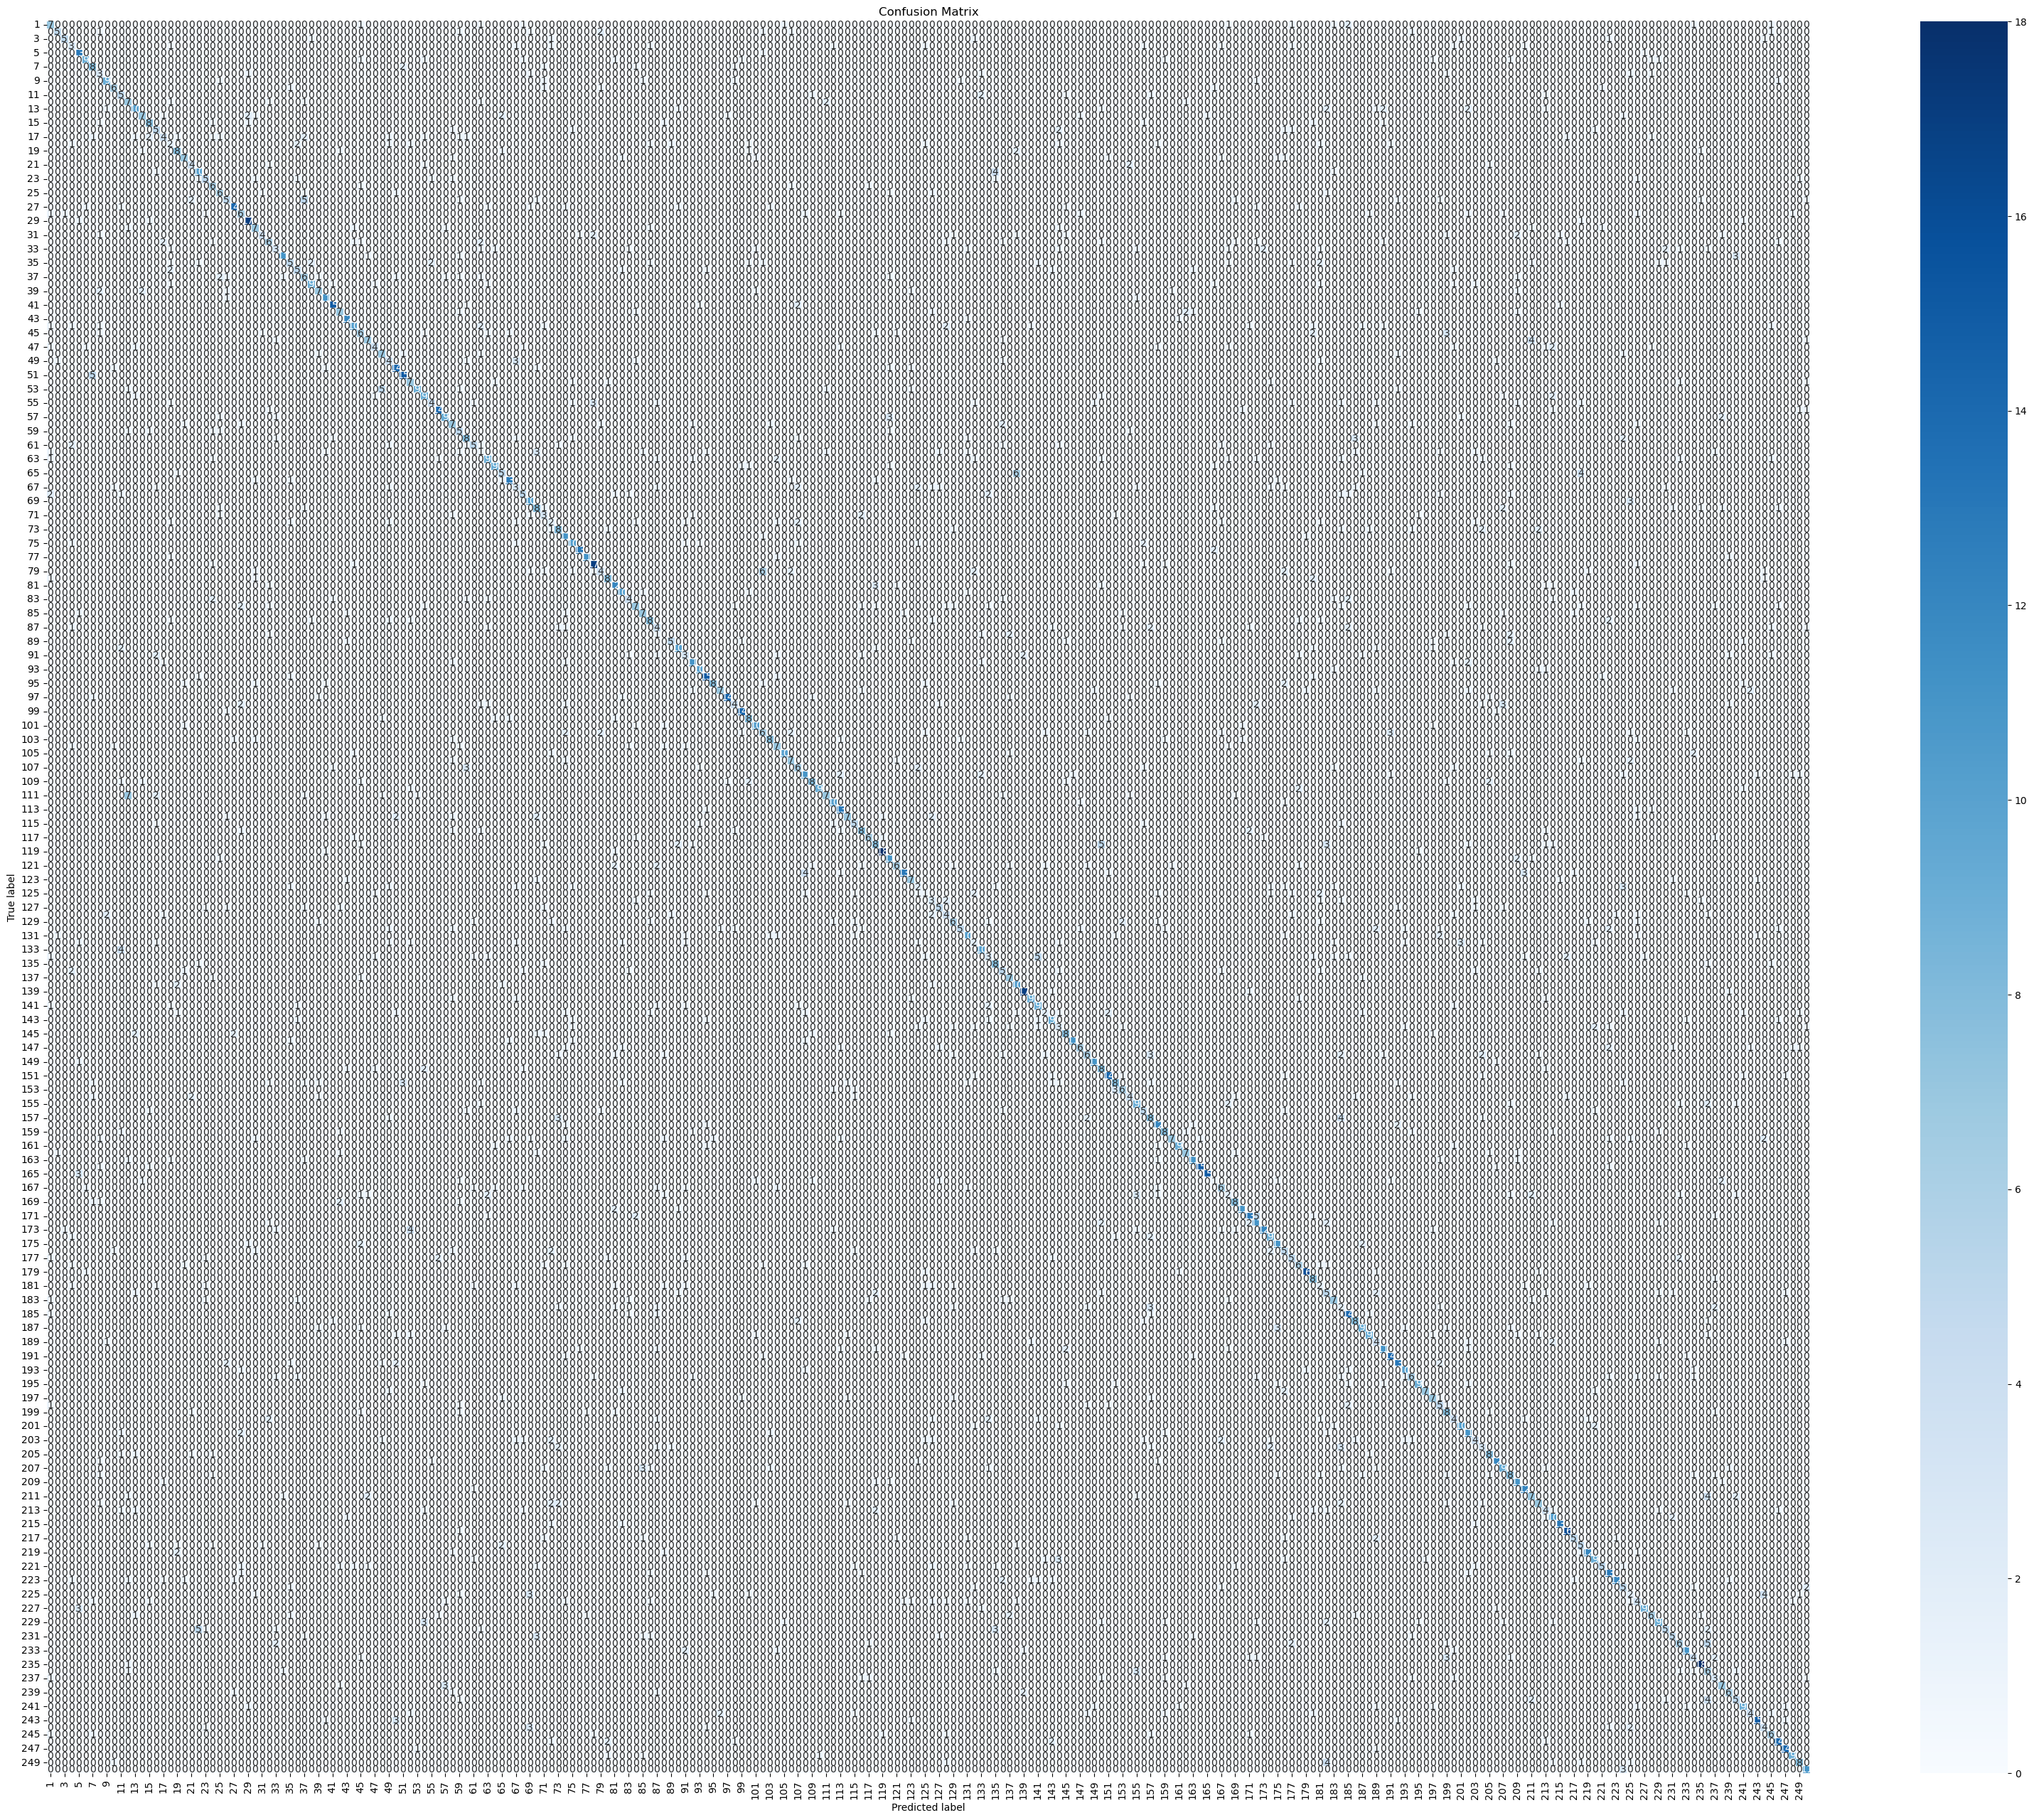

In [20]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# Get predictions
y_pred = model.predict(X_test_lda)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
# Plot confusion matrix
plt.figure(figsize=(40, 32))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

# Flatten the training and test sets for ANN
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_flat  = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Define your ANN model (input shape should be (500,))
ann_model = Sequential([
    Dense(1024, activation='relu', input_shape=(500,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(250, activation='softmax')
])

ann_model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

# Train the ANN model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_ann_model.h5", monitor='val_accuracy', save_best_only=True)
]

history = ann_model.fit(X_train_flat, y_train, 
                        validation_data=(X_test_flat, y_test),
                        epochs=50, 
                        batch_size=64, 
                        callbacks=callbacks, 
                        verbose=1)

# Load best weights (if you saved them)
ann_model.load_weights('best_ann_model.h5')

# Evaluate the ANN model
ann_accuracy = ann_model.evaluate(X_test_flat, y_test, verbose=0)[1]
print(f"ANN Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"ANN Accuracy: {ann_accuracy:.4f}")

/home/sahil-narkhede/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1364 - loss: 4.7579

250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.1368 - loss: 4.7547 - val_accuracy: 0.4038 - val_loss: 2.6528
Epoch 2/50
247/250 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4266 - loss: 2.4197

250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.4266 - loss: 2.4199 - val_accuracy: 0.4465 - val_loss: 2.3701
Epoch 3/50
247/250 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5421 - loss: 1.8141

250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5418 - loss: 1.8158 - val_accuracy: 0.4737 - val_loss: 2.2454
Epoch 4/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6066 - loss: 1.4694

250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6065 - loss: 1.4701 - val_accuracy: 0.4800 - val_loss: 2.1993
Epoch 5/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6652 - loss: 1.2213

250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6650 - loss: 1.2220 - val_accuracy: 0.4992 - val_loss: 2.2265
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7087 - loss: 1.0439 - val_accuracy: 0.4972 - val_loss: 2.2508
Epoch 7/50
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7377 - loss: 0.8984

250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7374 - loss: 0.8994 - val_accuracy: 0.5050 - val_loss: 2.2249
Epoch 8/50
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7711 - loss: 0.7830

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7708 - loss: 0.7838 - val_accuracy: 0.5123 - val_loss: 2.2700
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7914 - loss: 0.6952 - val_accuracy: 0.5077 - val_loss: 2.3221
ANN Training Accuracy: 0.7701
ANN Accuracy: 0.5123
